# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import Linear, CrossEntropyLoss, Module
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10
train_dataset = CIFAR10(root='./dataset',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
test_dataset = CIFAR10(root='./dataset', train=False,
                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [50]:
image, label = train_dataset[30]
print(len(train_loader))
print(image.size())
print(label)


782
torch.Size([3, 32, 32])
0


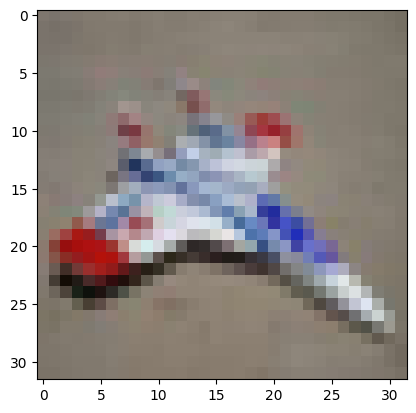

In [52]:
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()

In [5]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, 
# но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации
class Net(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = Linear(input_dim, 4 * hidden_dim)
        self.fc2 = Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        return x

In [6]:
net = Net(3072, 100, 10).cuda()

In [39]:
# Запустить обучение (по аналогии с тем, что делали на паре)
net.train()
epochs = 10
criterion = CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in tqdm(range(epochs)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'[{epoch + 1}, {(i + 1):5d}] loss: {(running_loss / 2000):.3f}')
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]

[1,     1] loss: 0.001
[1,   301] loss: 0.163
[1,   601] loss: 0.167


 10%|█         | 1/10 [00:11<01:41, 11.25s/it]

[2,     1] loss: 0.001
[2,   301] loss: 0.161
[2,   601] loss: 0.162


 20%|██        | 2/10 [00:22<01:27, 10.98s/it]

[3,     1] loss: 0.000
[3,   301] loss: 0.161
[3,   601] loss: 0.161


 30%|███       | 3/10 [00:33<01:16, 10.99s/it]

[4,     1] loss: 0.001
[4,   301] loss: 0.159
[4,   601] loss: 0.159


 40%|████      | 4/10 [00:43<01:05, 10.94s/it]

[5,     1] loss: 0.001
[5,   301] loss: 0.158
[5,   601] loss: 0.157


 50%|█████     | 5/10 [00:54<00:54, 10.92s/it]

[6,     1] loss: 0.001
[6,   301] loss: 0.156
[6,   601] loss: 0.158


 60%|██████    | 6/10 [01:05<00:43, 10.93s/it]

[7,     1] loss: 0.000
[7,   301] loss: 0.155
[7,   601] loss: 0.154


 70%|███████   | 7/10 [01:16<00:32, 10.95s/it]

[8,     1] loss: 0.001
[8,   301] loss: 0.151
[8,   601] loss: 0.156


 80%|████████  | 8/10 [01:27<00:21, 10.94s/it]

[9,     1] loss: 0.001
[9,   301] loss: 0.149
[9,   601] loss: 0.153


 90%|█████████ | 9/10 [01:38<00:10, 10.91s/it]

[10,     1] loss: 0.001
[10,   301] loss: 0.149
[10,   601] loss: 0.150


100%|██████████| 10/10 [01:49<00:00, 10.94s/it]

Training is finished!


In [48]:
net.eval()
for data in test_loader:
        inputs, labels = data[0].cuda(), data[1]
        pred = net(inputs).cpu()        
        display(pred)
        display(criterion(pred, labels))
        display(F.softmax(pred, dim=0))
        display(labels) 
        break

tensor([[ 0.1797,  0.1766,  1.4219,  2.8793,  0.7280,  1.6517, -0.2981, -4.4265,
          0.8833, -2.8804],
        [ 1.1190,  3.4831, -1.5654, -0.9504, -1.6033, -3.0461, -3.1869, -3.6298,
          5.6183,  4.4503],
        [ 5.2145,  2.0286, -0.1220, -1.9139, -0.4617, -2.4131, -6.3945, -0.9677,
          4.5860,  1.6557],
        [ 3.0624, -0.8891,  1.5417, -0.7824,  2.4427, -0.8810, -6.3945,  1.1126,
          2.8588, -1.6599]], grad_fn=<ToCopyBackward0>)

tensor(0.7926, grad_fn=<NllLossBackward0>)

tensor([[5.7114e-03, 2.8565e-02, 4.1820e-01, 9.4725e-01, 1.4376e-01, 9.0439e-01,
         9.4327e-01, 3.4549e-03, 6.1491e-03, 6.1570e-04],
        [1.4611e-02, 7.7956e-01, 2.1086e-02, 2.0571e-02, 1.3969e-02, 8.2436e-03,
         5.2488e-02, 7.6639e-03, 7.0014e-01, 9.3983e-01],
        [8.7765e-01, 1.8203e-01, 8.9303e-02, 7.8486e-03, 4.3747e-02, 1.5524e-02,
         2.1232e-03, 1.0979e-01, 2.4937e-01, 5.7463e-02],
        [1.0203e-01, 9.8411e-03, 4.7141e-01, 2.4333e-02, 7.9853e-01, 7.1844e-02,
         2.1232e-03, 8.7909e-01, 4.4336e-02, 2.0866e-03]],
       grad_fn=<SoftmaxBackward0>)

tensor([3, 8, 8, 0])